In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [2]:
# let's use Meshcat!
# CHANGE THIS DIRECTOR TO AVOID REBUILDING
# import os
# my_dir = '/Users/ethanweber/Documents/RobotLocomotionGroup/meshcat-python'
# os.chdir(my_dir+'/src')

import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

In [3]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [4]:
cube = vis["cube"]
pivot = cube["pivot"]
wheel = pivot["wheel"]

In [5]:
# set the initial state

x = 0.5
z = 0.2

x_dot = 0.0
z_dot = 0.0

thetay = 0.785398

# state of the flywheel
phi = 0.0
phi_dot = 0.0

torque = -0.0

# time of simulation (number of seconds)
time_of_sim = 2.0


state_initial = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,0.,0.,phi_dot)

In [6]:
# create and draw the cube
cube_dim = [1.0,1.0,1.0] # x,y,z
cube.set_object(g.Box(cube_dim))

In [7]:
state_initial[0:3]

(0.5, 0.0, 0.2)

In [8]:
def draw_transformation(state):
    state = list(state)
    origin = state[0:3]
    origin[2] += cube_dim[2]/2.0 # account for the floor
    theta = state[4]
    temp = tf.rotation_matrix(theta,[0,1,0]) # assume rotate about y
    temp[0:3, -1] = tf.translation_from_matrix(tf.translation_matrix(origin))
    cube.set_transform(temp)

In [9]:
draw_transformation(state_initial)

Num states: 14
Spawning PlanarRigidBodyVisualizer for tree with 1 actuators


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


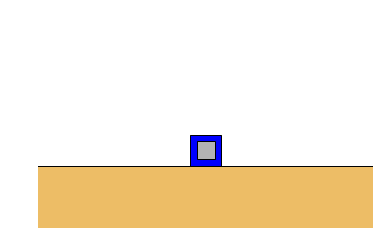

In [10]:
timestep = 0.0
builder = DiagramBuilder()
tree = RigidBodyTree(FindResource("cubli/cubli.urdf"),
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree, timestep)
nx = tree.get_num_positions() + tree.get_num_velocities()
print("Num states: {}".format(nx))

allmaterials = CompliantMaterial()
allmaterials.set_youngs_modulus(1E9) # default 1E9
allmaterials.set_dissipation(1.0) # default 0.32
allmaterials.set_friction(1.0) # default 0.9.
plant.set_default_compliant_material(allmaterials)

plant_context = plant.CreateDefaultContext()

robot = builder.AddSystem(plant)

torque_system = builder.AddSystem(ConstantVectorSource(
    np.ones((tree.get_num_actuators(), 1))*torque))
builder.Connect(torque_system.get_output_port(0),
                robot.get_input_port(0))

# what do xlim and ylim mean, what about -5 for the ground element
vis = builder.AddSystem(PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5]))
builder.Connect(robot.get_output_port(0),
                vis.get_input_port(0))

# And also log
signalLogRate = 60
signalLogger = builder.AddSystem(SignalLogger(nx))
signalLogger._DeclarePeriodicPublish(1. / signalLogRate, 0.0)
builder.Connect(robot.get_output_port(0),
                signalLogger.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(0.25)
simulator.set_publish_every_time_step(False)

In [11]:
context = simulator.get_mutable_context()
state = context.get_mutable_state().get_mutable_continuous_state().get_mutable_vector()
state.SetFromVector(state_initial)
simulator.StepTo(time_of_sim)

In [12]:
ani = vis.animate(signalLogger, repeat=True)
HTML(ani.to_html5_video())

In [13]:
cube_side = cube_dim[0]
# 45 degrees in radians, 0.785398
def contact_check(state):
    return True
    z = state[2] # grab the z state
    angle = state[4] % np.pi/2 # get the angle
    calc_height = cube_side*(np.sin(angle)+np.cos(angle))/2.0
    bottom = z - calc_height
    print("Z:{}".format(z))
    print("Calc_height:{}".format(calc_height))
    print("Bottom:{}".format(bottom))
    if bottom <= -.5:
        return True
    else:
        return False

In [14]:
def cube_guard(state):
    return True

In [15]:
def cube_contact(state, u):
    print("Contact")
    # Contact dynamics of cube
    
    # Need to grab important parameters
    M_c = 1.0 # self.M_c
    M_w = 1.0 # self.M_w
    M_t = M_c + M_w
    
    I_c = 1.0 #self.I_c
    I_w = 1.0 #self.I_w
    I_t = I_c + I_w
    
    # Distance from edge to center of cube
    L_t = np.sqrt(2)/2.0 # np.sqrt.(2*self.L)  
    
    # Assuming friction is 0 right now
    F_c = 0.5
    F_w = 0.5
    
    g = 9.81 # self.g
    
    # Relevant states are x,z,thetay, phi
    x = state[0]
    z = state[2]
    thetay = (state[4] - np.pi/4.0) % np.pi/4.0
    phi = state[6]
    
    xdot = state[7]
    zdot = state[9]
    thetaydot = state[11]
    phidot = state[13]
    
    # Setup the derivative of the state vector
    derivs = np.zeros_like(state)
    derivs[0:7] = state[7:]
    
    derivs[0] = -L_t*math.sin(thetay)*thetaydot
    derivs[2] = L_t*math.cos(thetay)*thetaydot
    
    # Cos issue taylor expansion
    cos_theta = 1 - thetay**2/2 + thetay**2/24
    
    # Dynamics while the block is on the ground
    # Right now, assumes enough friction in x direction to only rotate
    # Right now, assumes sticky ground so it only rotates.
    derivs[7] = 0.0 # Force balance in x, friction etc.  
    derivs[9] = 0.0 # Force balance in z, normal force 
    
    # Moment balance around center of block 
#     derivs[11] = (-L_t*M_t*g*cos_theta - u[0] + F_w*phidot - F_c*thetaydot)/I_c 
    derivs[11] = (-L_t*M_t*g*math.cos(thetay + np.pi/4.0) - u[0] - F_w*phidot + F_c*thetaydot)/I_c
    
    # Torque on the inertia wheel
    derivs[13] = (L_t*M_t*g*math.cos(thetay + np.pi/4.0) + u[0]*I_t - F_c*thetaydot*I_w + F_w*phidot*I_t)/(I_w*I_c)

    return derivs

In [16]:
def cube_ballistic(state, u):
    print("Ballistic")
    # Ballistic Dynamics of the cube
    
    # Need to grab important parameters
    M_c = 1.0 # self.M_c
    M_w = 1.0 # self.M_w
    M_t = M_c + M_w
    
    I_c = 1.0 #self.I_c
    I_w = 1.0 #self.I_w
    I_t = I_c + I_w
    
    # Distance from edge to center of cube
    L_t = np.sqrt(2) #np.sqrt.(2*self.L)  
    
    # Assuming friction is 0 right now
    F_c = 0.5
    F_w = 0.5
    
    g = 9.81 # self.g
    
    # Relevant states are x,z,thetay, phi
    x = state[0]
    z = state[2]
    thetay = state[4]
    phi = state[6]
    
    # Velocity States
    xdot = state[7]
    zdot = state[9]
    thetaydot = state[11]
    phidot = state[13]
    
    # Setup the derivative of the state vector
    derivs = np.zeros_like(state)
    derivs[0:7] = state[7:]
    
    # Ballistic Dynamics
    derivs[7] = 0.0 # No forces along x
    derivs[9] = -g  # Acceleration due to gravity
    
    # Back torque due to wheel
    derivs[11] = (-u[0] + F_w*phidot - F_c*thetaydot)/I_c
#     derivs[11] = 0.0
    # Wheel accel
    derivs[13] = (u[0]*I_t + F_c*thetaydot*I_w - F_w*phidot*I_t)/(I_w*I_c)
#     derivs[13] = 0.0
    
    return derivs     

In [17]:
def discrete_dynamics(state):
    # Takes in the current state at the point of contact
    # Outputs the new sate when you make contact
    state = list(state)
    state[9] = 0.
    return state

In [18]:
# get the dynamics
def cube_dynamics(state, u):
    if contact_check(state):
#         next_state = discrete_dynamics(state)
        return cube_contact(state,u)
    else:
        return cube_ballistic(state,u)

In [19]:
def compute_optimal_control(initial_state,final_state, min_time, max_time):
    # Setup solver
    mp = MathematicalProgram()

    # number knot points
    N = 50
    
    # Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used
    dt = time_used/(N+1)
    
    
    # Control decision variables
    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input for the cube
    u_over_time = u
    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time

    # State decision variabless
    x = mp.NewContinuousVariables(14, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(14, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time
    
    # State Constraints
    error_thresh = 0.001
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + cube_contact(total_x[n,:], total_u[n,:])*dt
#         dynamic_state_next = total_x[n,:] + cube_ballistic(total_x[n,:], total_u[n,:])*dt
        
        # Make sure the actual and predicted align to follow dynamics
        for j in range(14):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)

    # Quadratic Cost in control effort
    # TODO: Make this cost of transport, better measure of effort
    # COT = u^2/(m_tot*g*d)
    mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))

    # Add initial state constraint
    for i in range(14):
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)
    
    # Add final state constraint
    # Let's us specify where we want the cube to be
#     for i in range(14):
#         state_error = x_over_time[-1,i] - final_state[i]    
#         mp.AddConstraint(state_error <= 1)
#         mp.AddConstraint(state_error >= -1)
#     # Position Constraint
    x_error = x_over_time[-1,0] - final_state[0]
    mp.AddConstraint(x_error <= error_thresh)
    mp.AddConstraint(x_error >= -error_thresh)
    
    z_error = x_over_time[-1,2] - final_state[2]
    mp.AddConstraint(z_error <= error_thresh)
    mp.AddConstraint(z_error >= -error_thresh)
    
    theta_error = x_over_time[-1,4] - final_state[4]
    mp.AddConstraint(theta_error <= error_thresh)
    mp.AddConstraint(theta_error >= -error_thresh)
    
    # add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
#     mp.AddConstraint(time_used[0] <= maximum_time)

    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    
    
    return trajectory, input_trajectory, time_array

In [20]:
def plot_xz(trajectory):
    cube_x = trajectory[:,0] 
    cube_z = trajectory[:,2]
    
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(cube_x, cube_z)
#     axes.axis("equal")
    
    plt.show()

def plot_theta(trajectory, time_array):
    cube_theta = trajectory[:,4]
    print cube_theta.shape
    print time_array.shape
    fig, axes = plt.subplots(nrows=1, ncols=1)
    axes.plot(time_array, cube_theta)
#     axes.axis("equal")
    
    plt.show()
    
def plot_u(input_trajectory, time_array):
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(time_array, input_trajectory)
#     axes.axis("equal")
    
    plt.show()

In [21]:
# Set the inital condititions
x = 0.; z = 0.; thetay = 0.; phi = 0.; 
x_dot = 0.; z_dot = 0.; thetay_dot = 0.; phi_dot = 0.;

# Different starting places
origin_1 = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,thetay_dot,0.,phi_dot)
# origin_2 = (0.,0.,50,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.)

# Set the desired final conditions
swing_up = (-0.5,0.,np.sqrt(2)/2-0.5,0., np.pi/4,0.,phi,x_dot,0.,z_dot,0.,thetay_dot,0.,phi_dot)
# fall_down = (0.,0.,0.,0.,0.,0.0,0.,0.,0.,0.,0.,0.,0.,0.)

# Set the time constraints
minimum_time = 0.5; maximum_time = 15.

# Solve the trajectory optimization
traj, input_traj, time_array = compute_optimal_control(origin_1, swing_up, minimum_time, maximum_time)


Contact


TypeError: unsupported operand type(s) for %: 'pydrake._symbolic_py.Expression' and 'float'

In [ ]:
# Print trajectory information
print "Trajectory size: ", traj.shape
print "Input size: ", input_traj.shape
print "\n"

# Print initial conditions
print "Initial state: ", traj[0]
print "\n"

# Print final conditionsa
print "Final state: ", traj[-1]

print "Final time: ", time_array[-1]
print "Total energ: ", input_traj.dot(input_traj)

In [ ]:
# Plot
plot_xz(traj)
plt.plot(time_array, traj[:,4])
plt.show()
plot_u(input_traj, time_array[:-1])

In [ ]:
input_traj[-1]

In [ ]:
# code below here is trying to use meschat

In [ ]:
# simulate the trajectory in the simulation
traj[-1,:]

In [ ]:
len(traj)

In [26]:
import time

In [27]:
draw_transformation(traj[0,:].tolist())

NameError: name 'traj' is not defined

In [28]:
for i in range(len(traj)):
    draw_transformation(traj[i,:])
    time.sleep(.01)

NameError: name 'traj' is not defined

In [29]:
import random

In [36]:
angle = 1.2*np.pi/4
angle_vel = 0.0 # 5.0
current_state = (0.,0.,0.5,0.0,angle,0.,0.,0.,0.,0.,0.,angle_vel,0.,0.)
draw_transformation(current_state)

In [35]:
# code to simulate passive dynamics
sec = 2.0 # seconds
steps_per_sec = 1000.0 # discrete steps in a second
num_steps = sec*steps_per_sec # total number of steps
sec_per_step = sec/num_steps # number of seconds per step
for t in np.linspace(0,sec,num_steps):
    
    # update state
    # no input
    current_state = current_state + cube_dynamics(current_state,[0.0])*sec_per_step
    
    # update the state of the cart
    draw_transformation(current_state)
    time.sleep(sec_per_step)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact


Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
Contact
